- Epicycles
- Disruption details
- Bar
- Interactions with subhalos
- Interactions with more massive dwarfs (Sag, LMC)

In [18]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gala.units import galactic
from helpers import galcen_frame, get_frame_from_points
from scipy.spatial.transform import Rotation

%matplotlib inline

Phase-space position motivated by Pal 5:

In [2]:
# _c = coord.SkyCoord.from_name("Pal 5")

# allstar = at.Table.read("/Users/apricewhelan/data/APOGEE/DR17/allStarLite-dr17-synspec_rev1.fits")

# allstar_c = coord.SkyCoord(allstar["RA"], allstar["DEC"], unit=u.deg)
# mask = (
#     (allstar_c.separation(_c) < 0.5 * u.deg)
#     & (allstar["GAIAEDR3_PMRA"] < -2) & (allstar["GAIAEDR3_PMRA"] > -4)
#     & (allstar["GAIAEDR3_PMDEC"] < -2) & (allstar["GAIAEDR3_PMDEC"] > -4)
# )
# mask.sum()

# # plt.errorbar(
# #     allstar["GAIAEDR3_PMRA"][mask],
# #     allstar["VHELIO_AVG"][mask],
# #     allstar["VERR"][mask],
# #     ls='none'
# # )
# # plt.xlim(-4, -2)
# # # plt.ylim(-4, -2)

# rv = allstar["VHELIO_AVG"][mask]
# rv_err = allstar["VERR"][mask]
# rv = np.sum(rv / rv_err**2) / np.sum(1 / rv_err**2)
# rv

# c = coord.SkyCoord(
#     ra=_c.ra,
#     dec=_c.dec,
#     distance=20.6*u.kpc,
#     pm_ra_cosdec=-2.75 * u.mas/u.yr,
#     pm_dec=-2.69 * u.mas/u.yr,
#     radial_velocity=rv * u.km/u.s
# )
# w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)
pal5_w0 = gd.PhaseSpacePosition(
    [6.10666435, 0.21330404, 14.76810429] * u.kpc,
    [-47.76135071, -124.34059763, -11.96646005] * u.km / u.s,
)

Pal 5 galcen radius: 16 kpc, velocity ~ 140 km/s, ecc ~ 0.38

In [98]:
# w0 = gd.PhaseSpacePosition([13.0, 0, 8] * u.kpc, [0, -155, 0] * u.km / u.s)
w0 = gd.PhaseSpacePosition([12.0, 0, 5] * u.kpc, [0, -130, 0] * u.km / u.s)
# w0 = gd.PhaseSpacePosition([12.0, 0, 5] * u.kpc, [0, -100, 0] * u.km / u.s)
mw = gp.MilkyWayPotential2022()
# mw = gp.NFWPotential.from_M200_c(1e12*u.Msun, c=15., units=galactic)
orbit = mw.integrate_orbit(w0, dt=-1, t1=0, t2=-6 * u.Gyr)
orbit.pericenter(), orbit.apocenter(), orbit.eccentricity()

(<Quantity 5.47976949 kpc>, <Quantity 12.93306468 kpc>, <Quantity 0.40478805>)

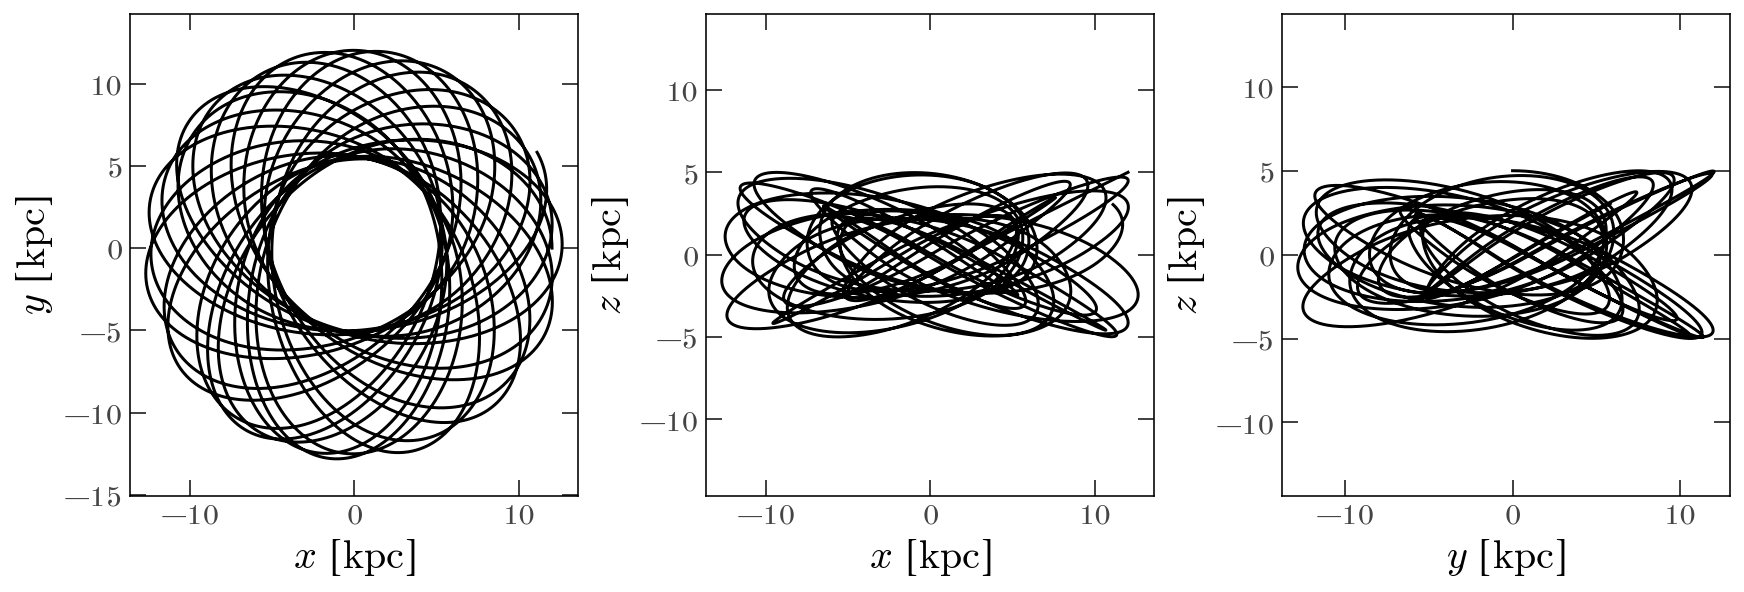

In [99]:
_ = orbit.plot()

# Epicycles:

In [100]:
df = gd.FardalStreamDF(gala_modified=False)
gen = gd.MockStreamGenerator(df, mw)
stream, prog = gen.run(
    w0,
    prog_mass=5e4 * u.Msun,
    dt=-0.2 * u.Myr,
    t1=0,
    t2=-5 * u.Gyr,
    release_every=1,
    n_particles=1,
)

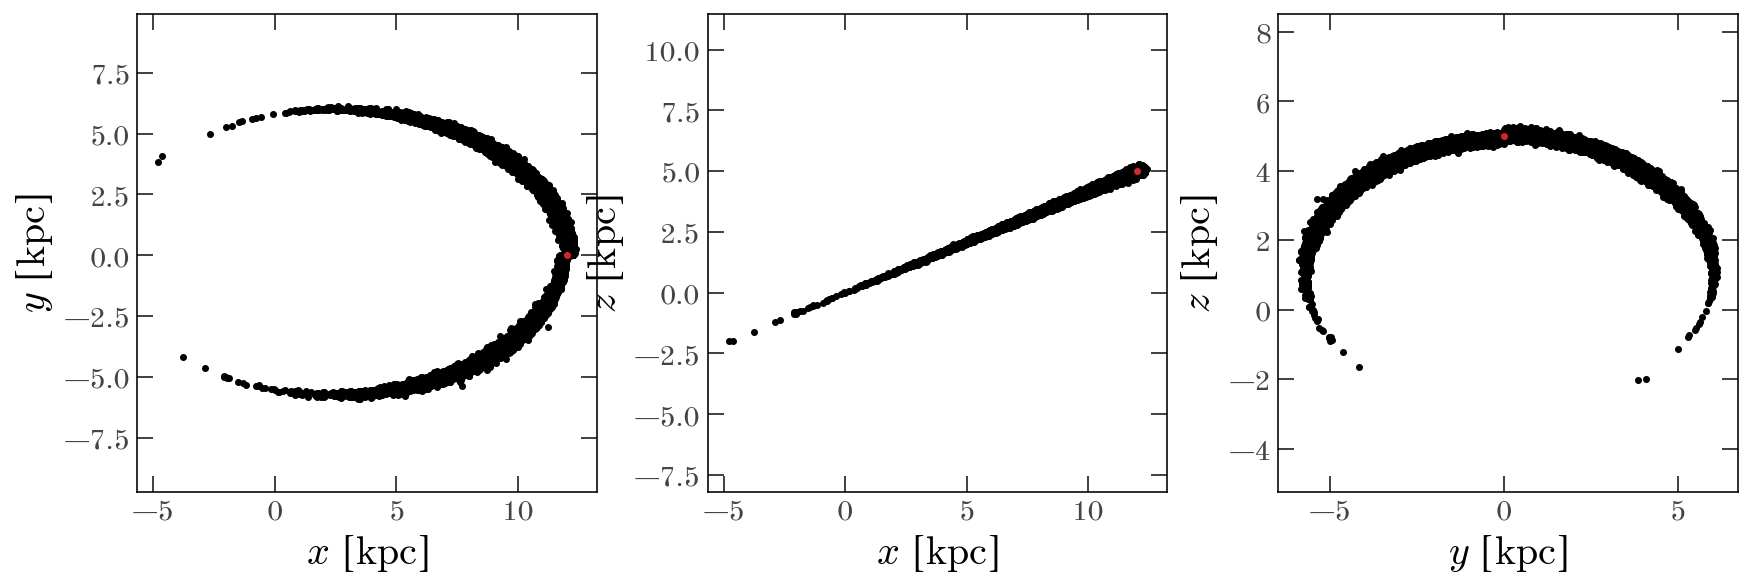

In [91]:
fig = stream.plot()
prog.plot(axes=fig.axes, color="tab:red");

In [92]:
ang = np.arctan2(prog.z, prog.x)[0]
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

In [93]:
stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
prog_rot.xyz.T

<Quantity [[ 1.30000000e+01, -2.31651069e-12, -8.88178420e-16]] kpc>

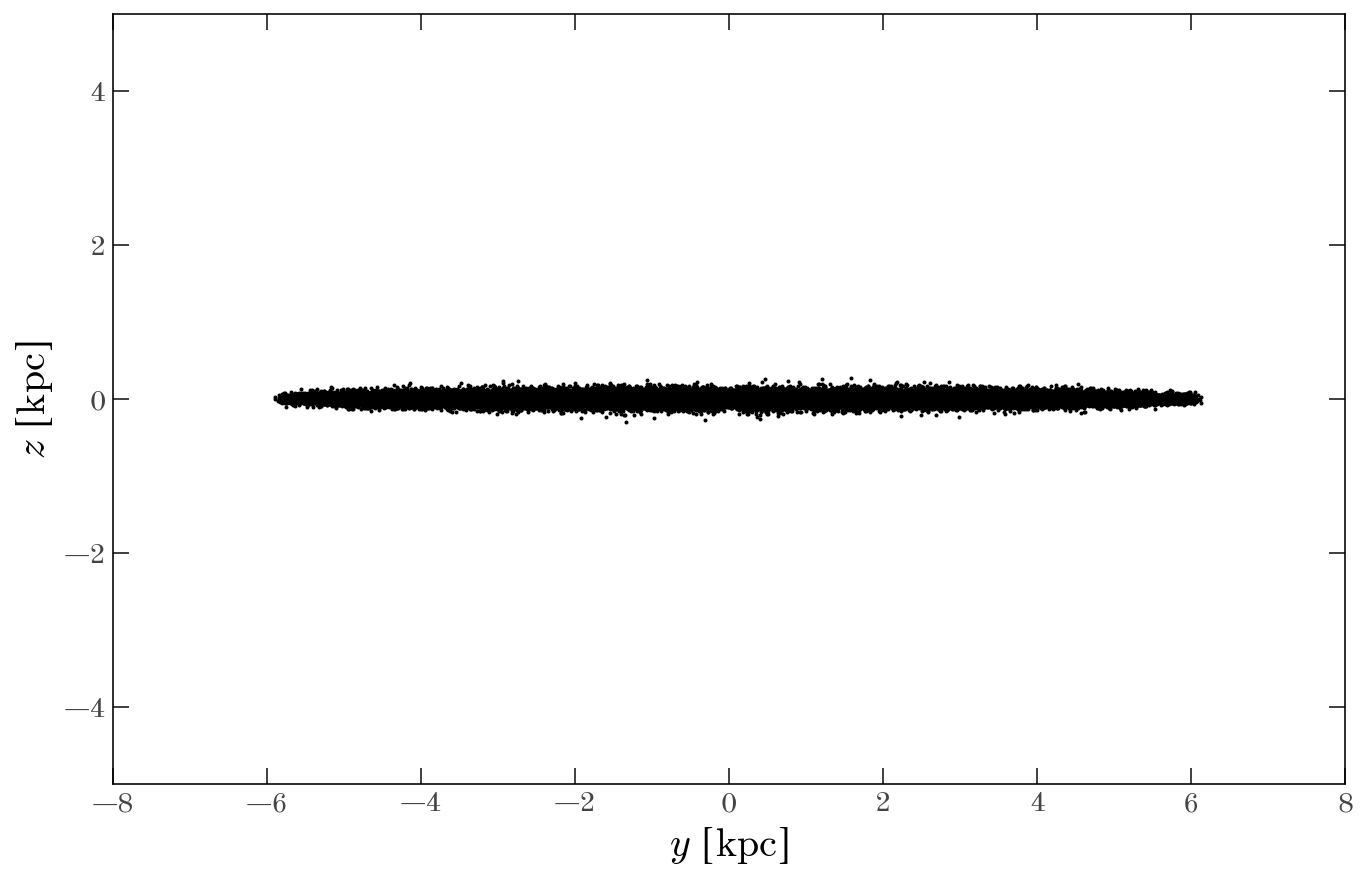

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
stream_rot.plot(
    ["y", "z"],
    plot_function=plt.plot,
    marker="o",
    ms=2,
    mew=0,
    ls="none",
    auto_aspect=False,
    axes=[ax],
)
ax.set(xlim=(-8, 8), ylim=(-5, 5), aspect=True);

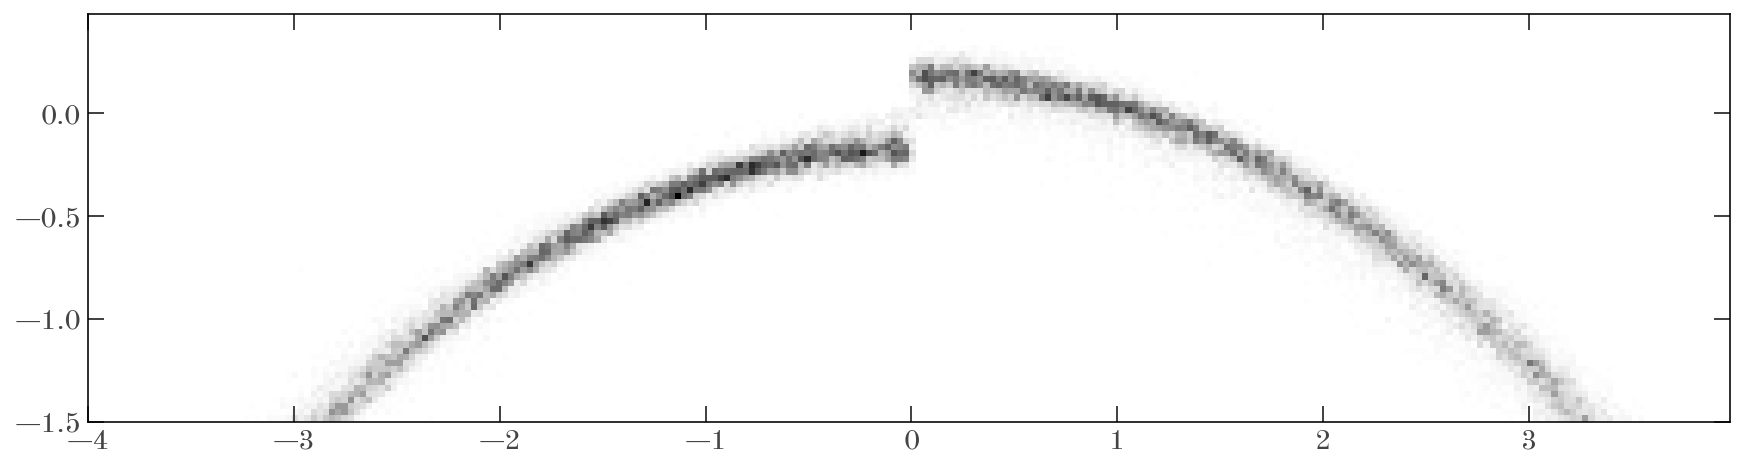

In [95]:
dx = 0.03

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
H, xe, ye = np.histogram2d(
    stream.y.value,
    stream.x.value - w0.x.value,
    bins=(np.arange(-4, 4 + 1e-3, dx), np.arange(-1.5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=True);

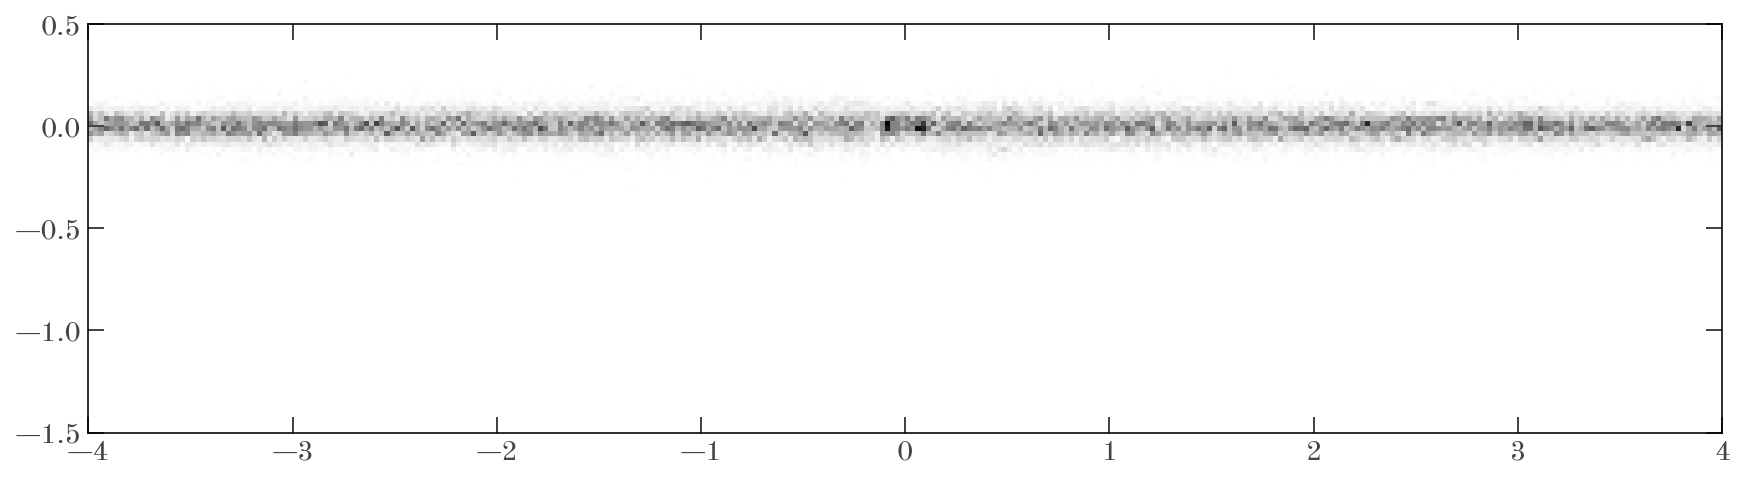

In [96]:
dx = 0.025

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
H, xe, ye = np.histogram2d(
    stream_rot.y.value,
    stream_rot.z.value,
    bins=(np.arange(-4, 4 + 1e-3, dx), np.arange(-1.5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=True);

# Mass-loss history

# Bar

In [22]:
mw_barred = gp.CCompositePotential()

# mw_barred["bar"] = gp.LongMuraliBarPotential(
#     m=4e9 * u.Msun,
#     a=2. * u.kpc,
#     b=1*u.kpc,
#     c=0.75*u.kpc,
#     alpha=-27 * u.deg,
#     units=galactic
# )
# mw_barred["disk"] = mw["disk"]
mw_barred["bar"] = gp.LongMuraliBarPotential(
    m=1e10 * u.Msun,
    a=3.0 * u.kpc,
    b=0.75 * u.kpc,
    c=0.5 * u.kpc,
    alpha=-27 * u.deg,
    units=galactic,
)
mw_barred["disk"] = mw["disk"].replicate(m=4.2e10 * u.Msun)
mw_barred["halo"] = mw["halo"]
mw_barred["nucleus"] = mw["nucleus"]

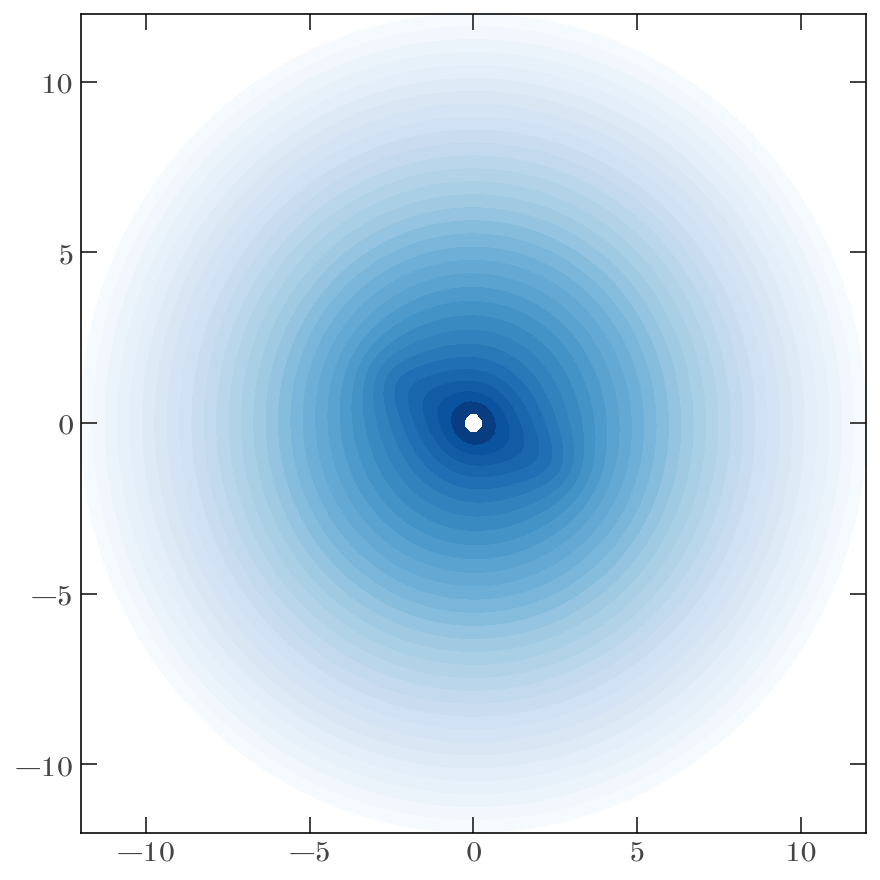

In [23]:
xxx = np.zeros((3, 128))
xxx[0] = np.linspace(1e-3, 12, xxx.shape[1])
dd = np.sort(mw_barred.density(xxx))[::4]
mw_barred.plot_density_contours(
    grid=(np.linspace(-12, 12, 128), np.linspace(-12, 12, 128), 0.0),
    levels=dd.value,
    norm=mpl.colors.LogNorm(),
);

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='$R$ [$\\mathrm{kpc}$]', ylabel='$v_{\\rm circ}$ [$\\mathrm{km\\,s^{-1}}$]'>)

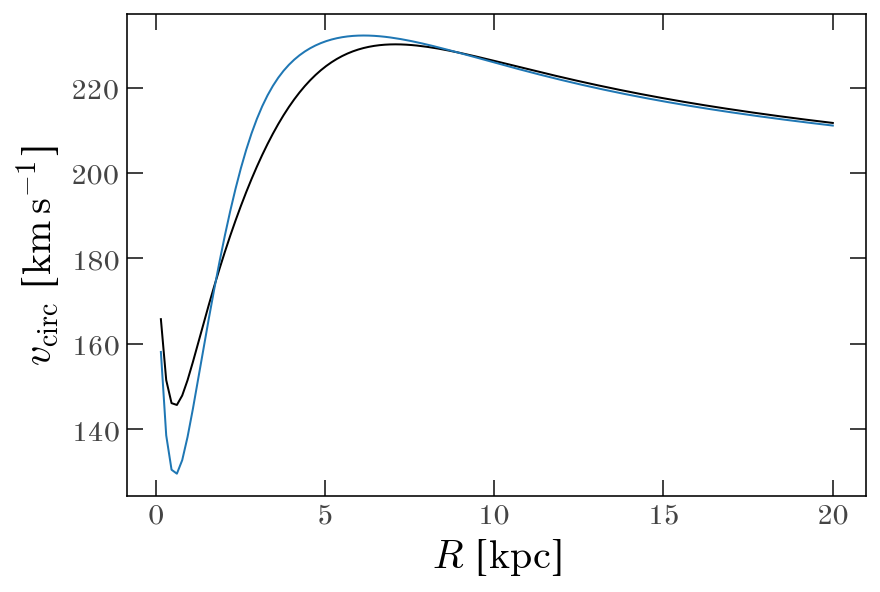

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
mw.plot_rotation_curve(np.linspace(0, 20, 128) * u.kpc, ax=ax)
mw_barred.plot_rotation_curve(np.linspace(0, 20, 128) * u.kpc, ax=ax)

In [25]:
# w0 = gd.PhaseSpacePosition([13.0, 0, 0] * u.kpc, [0, -100, 0] * u.km / u.s)

In [38]:
Omega = 38 * u.km / u.s / u.kpc

df = gd.FardalStreamDF(gala_modified=False)
bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, -1.0], units=galactic)
H = gp.Hamiltonian(mw_barred, bar_frame)
gen = gd.MockStreamGenerator(df, H)
stream, _ = gen.run(
    w0,
    prog_mass=5e4 * u.Msun,
    dt=-1 * u.Myr,
    t1=0,
    t2=-5 * u.Gyr,
    release_every=1,
    n_particles=1,
)

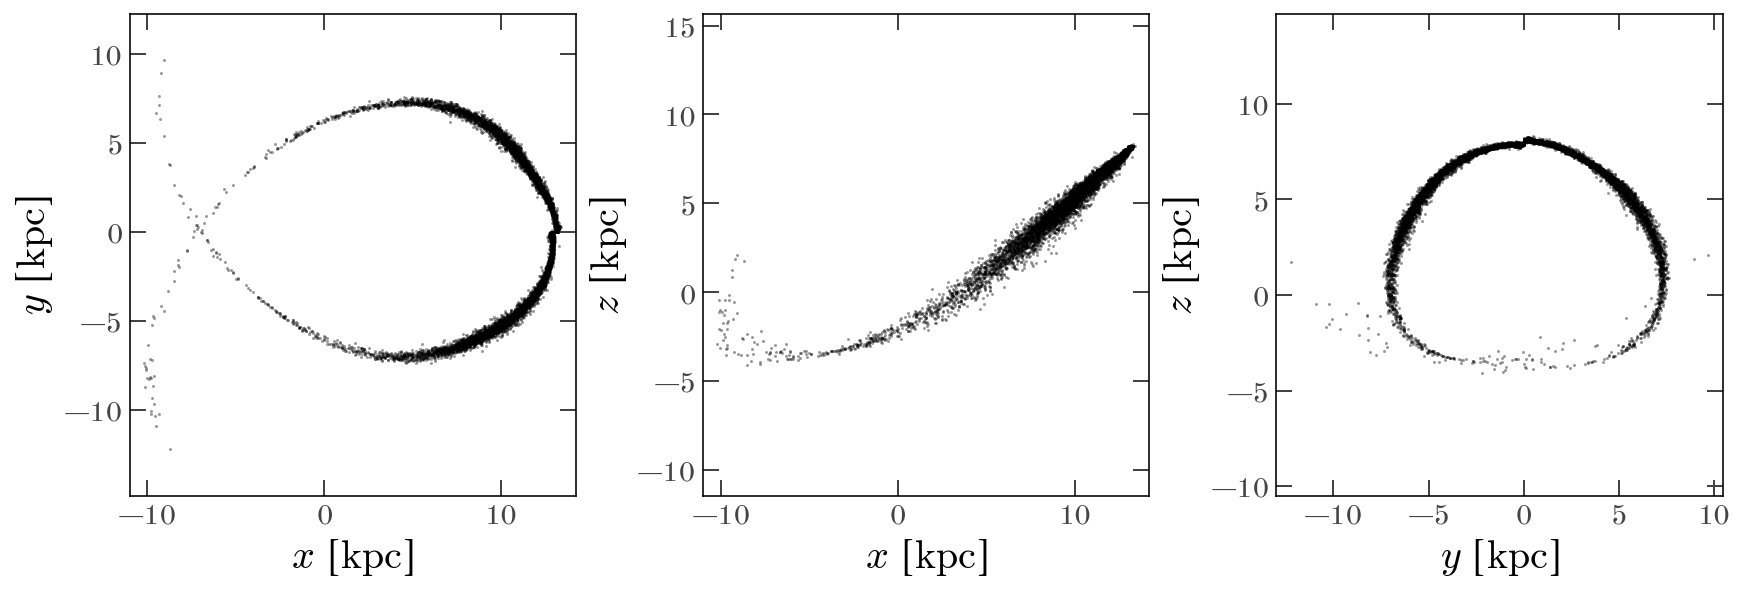

In [39]:
stream.plot(s=1, alpha=0.4);

In [40]:
df = gd.FardalStreamDF(gala_modified=False)
bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, 1.0], units=galactic)
H = gp.Hamiltonian(mw_barred, bar_frame)
gen = gd.MockStreamGenerator(df, H)
stream2, _ = gen.run(
    w0,
    prog_mass=5e4 * u.Msun,
    dt=-1 * u.Myr,
    t1=0,
    t2=-5 * u.Gyr,
    release_every=1,
    n_particles=1,
)

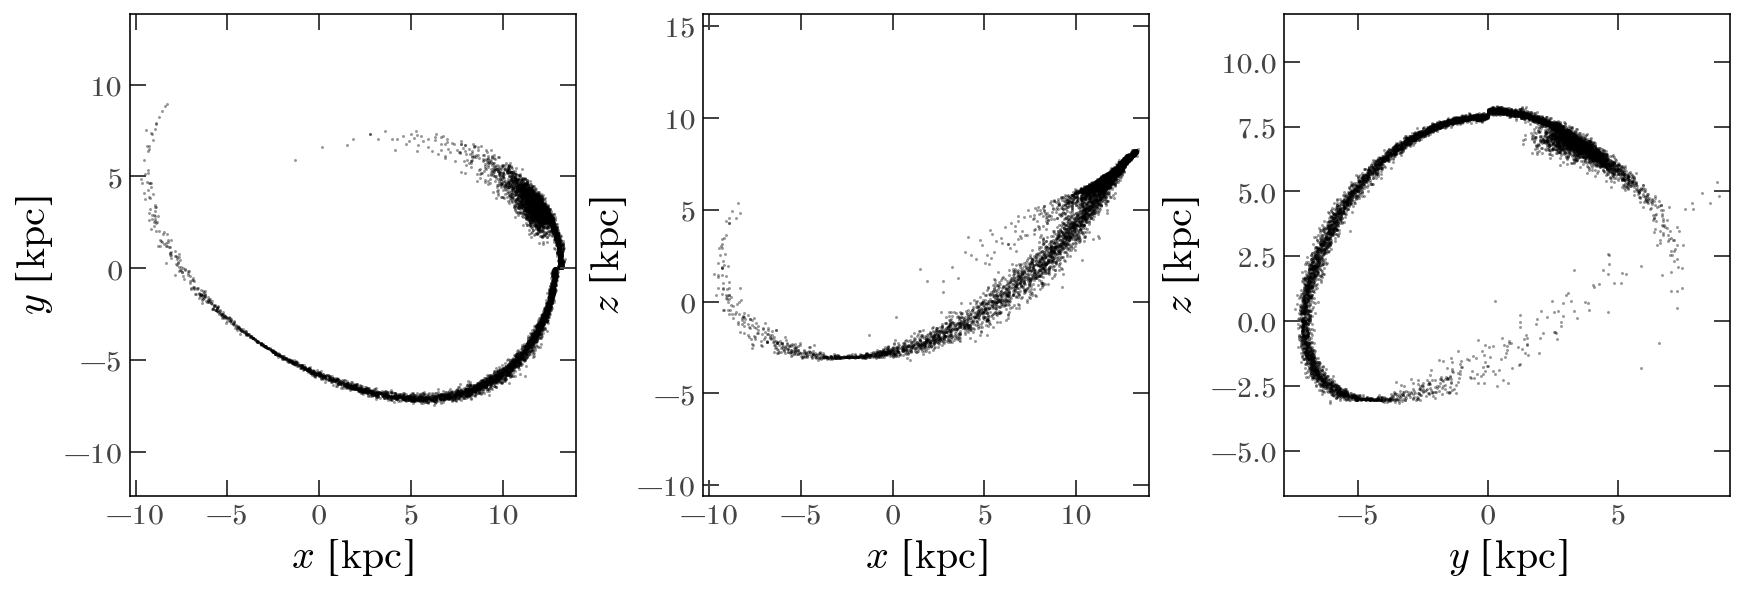

In [41]:
stream2.plot(s=1, alpha=0.4);

# Subhalo

# LMC